# Davos Data Project

# Goal:
## Generate data to support a story that demonstrates the value of Gecko's unique dataset


**Hypotheses:**
- Extreme Weather leads to outages due to increased energy demand and stress on the grid
    - Winter weather events , extreme cold
    - Summer and extreme heat
- What is the current state of US boilers, Gecko has inspected many recently, are they in good shape ?  How do we define good shape ?

# Table of Contents:

1. Data Overview
    - data
2. Environment Setup
3. Data Loading & Preprocessing
4. EDA & Visualization

# 1. Data Overview

- data
    - raw_data
        - **AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx**
            - AEP boiler tube leaks Jan 2011 - Aug 2022
            - Source: AEP, Wolpa
        - **All US Boilers.csv**
            - US Boilers
            - Source: IIR, Wolpa
        - **Duke Fleet Boiler tube failure data 2005 - 2020.csv**
            - Duke boiler tube leaks 2005 - 2020
            - Source: Duke, Connor
        - **salesforce.csv**
            - Gecko Salesforce data
            - Source: Gecko Salesforce
        - **portalservice_power_units**
            - all power industry units in portal data
            - Source: Gecko portal-service

# 2. Environment Setup

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import warnings
import zlib

# local
from etl.data_cleaning import generate_aep_outage_dfs, generate_duke_outage_dfs

Matplotlib Style:

In [2]:
plt.style.use('dark_background')
sns.set_style('darkgrid')

Get Current Working Directory:

In [3]:
wd = os.getcwd()
print(wd)

C:\Users\tom.fiorelli\Documents\GitHub\davos-data-project


Pandas Settings:

In [4]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

Disable Warnings:

In [5]:
warnings.filterwarnings('ignore')

# 3. EDA and Visualization

### Source 1:
AEP Plants 2011-20220802 Boiler Tube Leaks.xlsx

Description:

This dataset contains a large set of AEP tube failures across their steam fleet for a number of years

In [7]:
# get data
aep_df, active_aep_df = generate_aep_outage_dfs()

In [8]:
aep_df.shape

(2195, 18)

In [9]:
active_aep_df.shape

(1473, 18)

In [10]:
aep_df.head(1)

,Utility Name,Plant Name,Unit Name,Event Start Timestamp,Event End Timestamp,Event Type Code,Event Number,System Name,Component Name,Cause Code,Cause Description,Retired Flag,v_Event_Reduction,NERC Equivalent Hours,NERC MWH Loss,Unnamed: 15,Outage Month,Outage Week
0,AEP West Southwestern Electric Power Co,Pirkey,Pirkey 1,2010-12-31 03:19:59.999,2011-01-02 00:12:00,U1,123.0,Boiler,Boiler Tube Leaks,1000,Waterwall (Furnace wall),N,675.0,24.2,16335.0,Keep,12,52


In [11]:
active_aep_df.head(1)

,Utility Name,Plant Name,Unit Name,Event Start Timestamp,Event End Timestamp,Event Type Code,Event Number,System Name,Component Name,Cause Code,Cause Description,Retired Flag,v_Event_Reduction,NERC Equivalent Hours,NERC MWH Loss,Unnamed: 15,Outage Month,Outage Week
0,AEP West Southwestern Electric Power Co,Pirkey,Pirkey 1,2010-12-31 03:19:59.999,2011-01-02 00:12:00,U1,123.0,Boiler,Boiler Tube Leaks,1000,Waterwall (Furnace wall),N,675.0,24.2,16335.0,Keep,12,52


In [12]:
set(aep_df['System Name'])

{'Boiler', 'HRSG Boiler', 'Heat Recovery Steam Generator (HRSG)'}

In [13]:
active_aep_df['Event Start Timestamp'].min()

Timestamp('2010-12-31 03:19:59.999000')

In [14]:
active_aep_df['Event Start Timestamp'].max()

Timestamp('2022-06-25 06:25:00')

In [15]:
active_aep_df['Plant Name'].nunique()

26

In [31]:
active_aep_df['Unit Name'].nunique()

57

In [16]:
set(active_aep_df['Cause Description'])

{'Boiler screen, wing wall, or slag screen (water tubes only)',
 'Convection pass wall (water tubes only)',
 'Economizer',
 'External reheater link tubing',
 'External superheater link tubing',
 'First reheater',
 'First superheater',
 'Generating tubes',
 'HP Evaporator tubes',
 'HP economizer',
 'HP reheater',
 'HP superheater',
 'LP Evaporator tubes',
 'Other HRSG tube problems',
 'Other boiler tube leaks',
 'Platen superheater',
 'Second reheater',
 'Second superheater',
 'Steam generating tubes between steam drum and mud drum',
 'Waterwall (Furnace wall)'}

In [18]:
component_df = active_aep_df.groupby(['Cause Description'])['Event Start Timestamp'].nunique().to_frame().sort_values(by='Event Start Timestamp', ascending=False).reset_index()

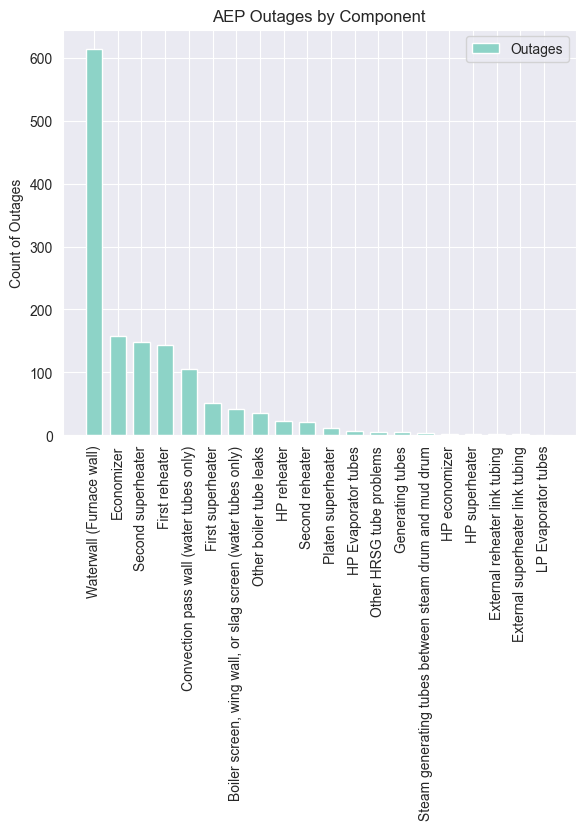

In [19]:
fig, ax = plt.subplots()

x = component_df["Cause Description"]
y = component_df["Event Start Timestamp"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('AEP Outages by Component')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(component_df["Cause Description"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [21]:
aep_month_outage_df = active_aep_df.groupby(['Outage Month'])['Event Start Timestamp'].nunique().to_frame().reset_index()

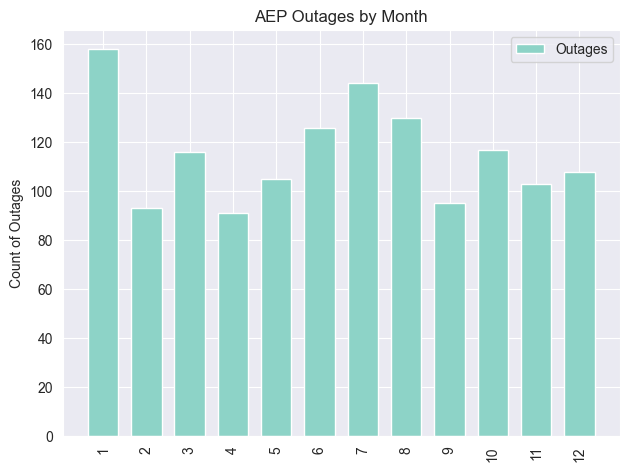

In [22]:
fig, ax = plt.subplots()

x = aep_month_outage_df["Outage Month"]
y = aep_month_outage_df["Event Start Timestamp"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('AEP Outages by Month')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(aep_month_outage_df["Outage Month"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [25]:
plant_outages_df = active_aep_df.groupby(['Plant Name'])['Event Start Timestamp'].nunique().to_frame().reset_index().sort_values(by='Event Start Timestamp', ascending=False)

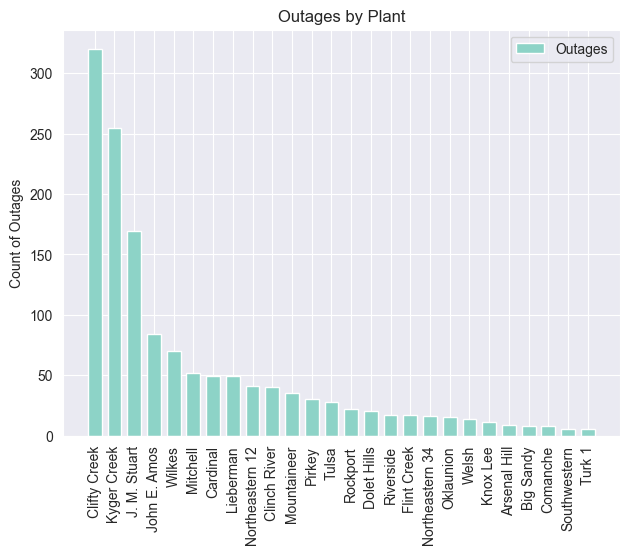

In [26]:
fig, ax = plt.subplots()

x = plant_outages_df["Plant Name"]
y = plant_outages_df["Event Start Timestamp"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('Outages by Plant')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [27]:
outage_duration_df = active_aep_df.groupby(['Plant Name'])['NERC Equivalent Hours'].sum().to_frame().reset_index().sort_values(by='NERC Equivalent Hours', ascending=False)

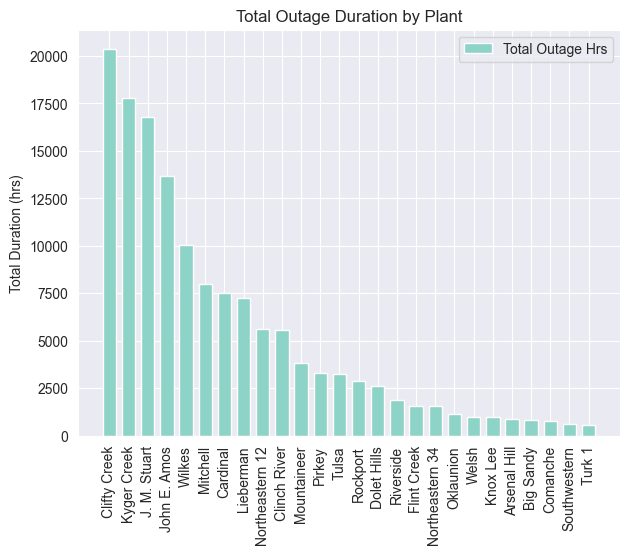

In [28]:
fig, ax = plt.subplots()

x = outage_duration_df["Plant Name"]
y = outage_duration_df["NERC Equivalent Hours"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Total Outage Hrs')
ax.set_title('Total Outage Duration by Plant')
ax.set_ylabel('Total Duration (hrs)')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

In [29]:
outage_mwh_df = active_aep_df.groupby(['Plant Name'])['NERC MWH Loss'].sum().to_frame().reset_index().sort_values(by='NERC MWH Loss', ascending=False)

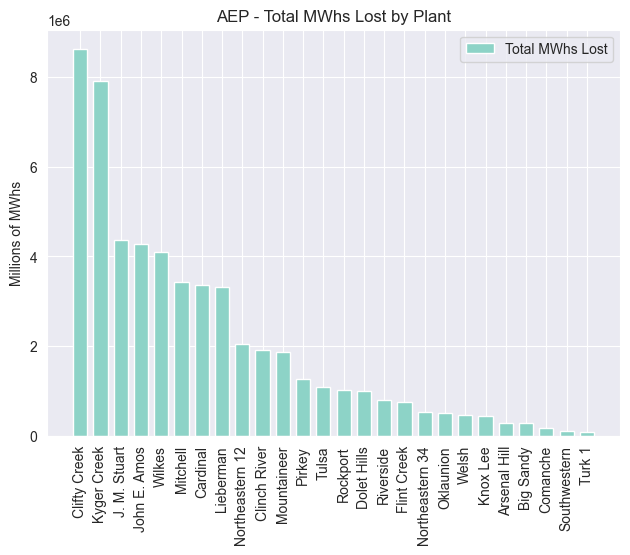

In [30]:
fig, ax = plt.subplots()

x = outage_mwh_df["Plant Name"]
y = outage_mwh_df["NERC MWH Loss"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Total MWhs Lost')
ax.set_title('AEP - Total MWhs Lost by Plant')
ax.set_ylabel('Millions of MWhs')
ax.set_xticks(x)
ax.set_xticklabels(plant_outages_df["Plant Name"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

### Source 2:
All US Boilers.csv

In [36]:
us_boilers_df = pd.read_csv(r"data/raw_data/All US Boilers.csv")

In [37]:
us_boilers_df.head()

,PARENTNAME,OWNER_NAME,OPER_NAME,PLANT_NAME,PHYS_CITY,P_COUNTY,UNIT_STATE,P_ST_NAME,P_COUNTRY,MARKET_REG,WORLD_REG,IND_CODE_DESC,SIC_CODE,PLANT_ID,UNIT_NAME,UNIT_ID,UNIT_TYPE,OUT_DESIGN,KO_DATE,STARTUP,STARTYEAR,SHUTDOWN,PRIM_FUEL,SECND_FUEL,FUEL_GROUP,HEAT_RATE,PWR_USAGE,U_STATUS,BOIL_NAME,BOILERTYPE,BMFR_NAME,BOIL_INFO,STEAM,STEAM_UOM,STEAM_TON,PRESSURE,PRES_UOM,PRES_BAR,TEMP,TEMP_UOM,TEMP_CEL,DESIGNFIRM,CONSTFIRM,MMBTU_HR,KO_YEAR,LATITUDE,LONGITUDE,COGEN_CHP
0,The Blackstone Group Incorporated,Lightstone Generation LLC,Lightstone Generation LLC,James Gavin Power Station,Cheshire,Gallia,OH,Ohio,U.S.A.,Great Lakes,North America,Power,4911,1010019,James Gavin 02,1003920,Steam Turbine,1300.0,NaN,1-Jul-75,1975,1-Dec-35,Coal Bituminous,Fuel Oil No. 2 Distillate Diesel,Coal,9799.0,Base Load,Operational,Boiler 02,Dry Bottom Boiler,Babcock & Wilcox,Opposed-Fired SCR LNB ESP-CS FGD-WS Trona,9775000.0,lbs/hr,4887.5,3685.0,PSIG,254.0,1010.0,deg F,543.0,AEP Pro Serv,AEP Pro Serv,NaN,NaN,38.934700,-82.115800,0
1,American Electric Power Company Incorporated,Appalachian Power Company,Appalachian Power Company,John Amos Power Station,Winfield,Putnam,WV,West Virginia,U.S.A.,Mid Atlantic,North America,Power,4911,1516038,John E Amos 03,1007895,Steam Turbine,1300.0,NaN,1-Oct-73,1973,1-Dec-33,Coal Bituminous,Fuel Oil No. 2 Distillate Diesel,Coal,9597.0,Intermediate Load,Operational,Boiler 03,Dry Bottom Boiler,Babcock & Wilcox,UP-101 PC Opposed-Fired SCR LNB ESP-CS (FGD-WS...,9775000.0,lbs/hr,4887.5,3700.0,PSIG,255.0,1000.0,deg F,538.0,American Electric Power,American Electric Power,11936.0,NaN,38.473069,-81.822458,0
2,Tennessee Valley Authority,Tennessee Valley Authority,Tennessee Valley Authority,Cumberland Fossil Power Station,Cumberland City,Stewart,TN,Tennessee,U.S.A.,Southeast,North America,Power,4911,1012869,Cumberland 01,1003702,Steam Turbine,1300.0,1-Jan-68,1-Mar-73,1973,31-Dec-28,Coal Bituminous,NaN,Coal,9678.0,Base Load,Operational,Boiler 01,Dry Bottom Boiler,Babcock & Wilcox,PC Opposed-Fired LNB SCR ESP-CS FGD-WS,9300000.0,lbs/hr,4650.0,3500.0,PSIG,241.0,1003.0,deg F,539.0,Black & Veatch,NaN,NaN,1968.0,36.391944,-87.655555,0
3,Tennessee Valley Authority,Tennessee Valley Authority,Tennessee Valley Authority,Cumberland Fossil Power Station,Cumberland City,Stewart,TN,Tennessee,U.S.A.,Southeast,North America,Power,4911,1012869,Cumberland 02,1003703,Steam Turbine,1300.0,1-Jan-68,1-Nov-73,1973,31-Dec-26,Coal Bituminous,NaN,Coal,9678.0,Intermediate Load,Operational,Boiler 02,Dry Bottom Boiler,Babcock & Wilcox,PC Opposed-Fired ESP LNB SCR FGD-WS,9300000.0,lbs/hr,4650.0,3500.0,PSIG,241.0,1003.0,deg F,539.0,Black & Veatch,NaN,NaN,1968.0,36.391944,-87.655555,0
4,The Blackstone Group Incorporated,Lightstone Generation LLC,Lightstone Generation LLC,James Gavin Power Station,Cheshire,Gallia,OH,Ohio,U.S.A.,Great Lakes,North America,Power,4911,1010019,James Gavin 01,1003919,Steam Turbine,1300.0,NaN,1-Oct-74,1974,1-Dec-35,Coal Bituminous,Fuel Oil No. 2 Distillate Diesel,Coal,9799.0,Base Load,Operational,Boiler 01,Dry Bottom Boiler,Babcock & Wilcox,Opposed-Fired SCR LNB ESP-CS FGD-WS Trona,9775000.0,lbs/hr,4887.5,3685.0,PSIG,254.0,1010.0,deg F,543.0,Black & Veatch,NaN,NaN,NaN,38.934700,-82.115800,0


In [38]:
set(us_boilers_df.PWR_USAGE)

{'Base Load', 'Intermediate Load', 'Peak Load'}

In [39]:
## NOTE : heat rate , lower is better

In [40]:
us_boilers_df.shape

(2538, 48)

In [41]:
us_boilers_df.columns

Index(['PARENTNAME', 'OWNER_NAME', 'OPER_NAME', 'PLANT_NAME', 'PHYS_CITY',
       'P_COUNTY', 'UNIT_STATE', 'P_ST_NAME', 'P_COUNTRY', 'MARKET_REG',
       'WORLD_REG', 'IND_CODE_DESC', 'SIC_CODE', 'PLANT_ID', 'UNIT_NAME',
       'UNIT_ID', 'UNIT_TYPE', 'OUT_DESIGN', 'KO_DATE', 'STARTUP', 'STARTYEAR',
       'SHUTDOWN', 'PRIM_FUEL', 'SECND_FUEL', 'FUEL_GROUP', 'HEAT_RATE',
       'PWR_USAGE', 'U_STATUS', 'BOIL_NAME', 'BOILERTYPE', 'BMFR_NAME',
       'BOIL_INFO', 'STEAM', 'STEAM_UOM', 'STEAM_TON', 'PRESSURE', 'PRES_UOM',
       'PRES_BAR', 'TEMP', 'TEMP_UOM', 'TEMP_CEL', 'DESIGNFIRM', 'CONSTFIRM',
       'MMBTU_HR', 'KO_YEAR', 'LATITUDE', 'LONGITUDE', 'COGEN_CHP'],
      dtype='object')

In [42]:
set(us_boilers_df['WORLD_REG'])

{'North America'}

In [43]:
set(us_boilers_df['MARKET_REG'])

{'Atlantic Canada',
 'Great Lakes',
 'Mid Atlantic',
 'Midwest',
 'New England',
 'Northeast',
 'Ontario',
 'Rocky Mountains',
 'Southeast',
 'Southwest',
 'West Coast',
 'Western Canada'}

In [185]:
us_boilers_df.groupby(['MARKET_REG', 'PARENTNAME', 'OWNER_NAME', 'OPER_NAME', 'PLANT_NAME'])['UNIT_ID'].nunique().to_frame().head(20)

UNIT_ID
MARKET_REG      PARENTNAME                 OWNER_NAME                          OPER_NAME                           PLANT_NAME                                          
Atlantic Canada Emera Incorporated         Nova Scotia Power Corporation       Nova Scotia Power Corporation       Glace Bay Power Station                            5
                                                                                                                   Lingan Thermal Generating Station                  4
                                                                                                                   Point Aconi Thermal Generating Station             1
                                                                                                                   Point Tupper Generating Station                    1
                                                                                                                   Trenton Thermal Generating Station                 2
                Energie NB Power           Energie NB Power                    Energie NB Power                    Belledune Power Station                            1
                                                                                                                   Coleson Cove Power Station                         3
                                                                                                                   Dalhousie Generating Station                       2
Great Lakes     AES Corporation            AES Indiana                         AES Indiana                         Harding Street Generating Station                  5
                                                                                                                   PI Eagle Valley Power Plant (H T Pritchard)        6
                                                                                                                   Petersburg Generating Station                      4
                                           AES Ohio                            Dayton Power & Light Company        J M Stuart Generating Station                      4
                                           Dayton Power & Light Company        Dayton Power & Light Company        Killen Power Station                               1
                Alcoa Corporation          Alcoa Power Generating Incorporated Alcoa Power Generating Incorporated Warrick Generating Station                         4
                Alliant Energy Corporation Wisconsin Power and Light Company   Wisconsin Power and Light Company   Columbia Energy Center                             2
                                                                                                                   Edgewater Generating Station                       3
                                                                                                                   Nelson Dewey Power Station                         2
                                                                                                                   Rock River Power Station                           2
                Ameren Corporation         Ameren Corporation                  Ameren Corporation                  Hutsonville Generating Station                     2
                                           Ameren Missouri                     Ameren Missouri                     Venice Power Station                               6

In [45]:
us_boilers_df['PARENTNAME'].nunique()

320

In [46]:
us_boilers_df['UNIT_ID'].nunique()

2286

In [47]:
us_boilers_df.loc[:, ('SHUTDOWN', 'U_STATUS', 'KO_YEAR')].head()

,SHUTDOWN,U_STATUS,KO_YEAR
0,1-Dec-35,Operational,NaN
1,1-Dec-33,Operational,NaN
2,31-Dec-28,Operational,1968.0
3,31-Dec-26,Operational,1968.0
4,1-Dec-35,Operational,NaN


In [48]:
set(us_boilers_df['U_STATUS'])

{'Closed', 'Mothballed', 'Operational', 'Removed', 'Shuttered'}

In [49]:
us_boilers_byparent = us_boilers_df[us_boilers_df['U_STATUS']=='Operational'].groupby(['PARENTNAME'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False).reset_index()

In [50]:
us_boilers_byparent.head(10)

,PARENTNAME,UNIT_ID
0,American Electric Power Company Incorporated,43
1,Vistra Energy Corporation,41
2,Xcel Energy Incorporated,35
3,Southern Company,29
4,Duke Energy Corporation,29
5,Berkshire Hathaway Incorporated,27
6,Covanta Holding Corporation,26
7,Tennessee Valley Authority,25
8,NRG Energy Incorporated,23
9,Entergy Corporation,21


In [51]:
us_boilers_byparent.UNIT_ID.sum()

1005

In [186]:
us_boilers_df.groupby(['FUEL_GROUP', 'PRIM_FUEL', 'SECND_FUEL'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False).head(20)

UNIT_ID
FUEL_GROUP       PRIM_FUEL                 SECND_FUEL                               
Natural Gas      Natural Gas               Fuel Oil No. 2 Distillate Diesel      209
                                           Fuel Oil No. 6 Residual               148
Coal             Coal Subbituminous        Natural Gas                           142
                 Coal Bituminous           Fuel Oil No. 2 Distillate Diesel      131
                                           Natural Gas                           115
                 Coal Subbituminous        Coal Bituminous                       112
                 Coal Bituminous           Coal Subbituminous                     61
                 Coal Subbituminous        Fuel Oil No. 2 Distillate Diesel       55
Renewable Energy Waste (solid/sludge)      Natural Gas                            46
Fuel Oil         Fuel Oil No. 6 Residual   Natural Gas                            43
Coal             Coal Bituminous           Petroleum Coke                         30
Natural Gas      Combined Cycle Waste Heat Natural Gas                            22
Fuel Oil         Fuel Oil No. 6 Residual   Fuel Oil No. 2 Distillate Diesel       21
Renewable Energy Waste (solid/sludge)      Fuel Oil No. 2 Distillate Diesel       19
Natural Gas      Natural Gas               Fuel Oil No. 5 Residual                17
Coal             Coal Bituminous           Fuel Oil No. 6 Residual                14
Natural Gas      Natural Gas               Fuel Oil                               14
Coal             Coal Lignite              Coal Subbituminous                     13
                 Coal Bituminous           Coal Waste                             12
Renewable Energy Wood                      Natural Gas                            12

In [53]:
us_boilers_df[us_boilers_df['U_STATUS']=='Operational'].groupby(['FUEL_GROUP'])['UNIT_ID'].nunique().to_frame().sort_values(by='UNIT_ID', ascending=False)

,UNIT_ID
FUEL_GROUP,
Coal,472
Natural Gas,350
Renewable Energy,106
Fuel Oil,77


### Source 3:
Duke Fleet Boiler tube failure data 2005 - 2020.csv

In [ ]:
duke_df = generate_duke_outage_dfs()

In [187]:
duke_df.shape

(1184, 8)

In [55]:
duke_df.head()

,Event ID,Station-Unit,Start Date,Cause Code Name,IsRepeat,TimeBetweenFailure
0,31289,East Bend Steam-2,1/4/05 9:41,Waterwall (Furnace wall) A,False,NaN
1,31290,East Bend Steam-2,1/4/05 10:23,Waterwall (Furnace wall) A,True,0.700000
2,34085,Gibson Steam-3,1/14/05 11:31,Waterwall (Furnace wall) A,False,NaN
3,34086,Gibson Steam-3,1/14/05 14:11,Waterwall (Furnace wall) A,True,2.666667
4,34087,Gibson Steam-3,1/16/05 2:41,Waterwall (Furnace wall) A,True,36.500000


In [58]:
duke_month_outages_df = duke_df.groupby(['Outage Month'])['Event ID'].nunique().to_frame().reset_index()

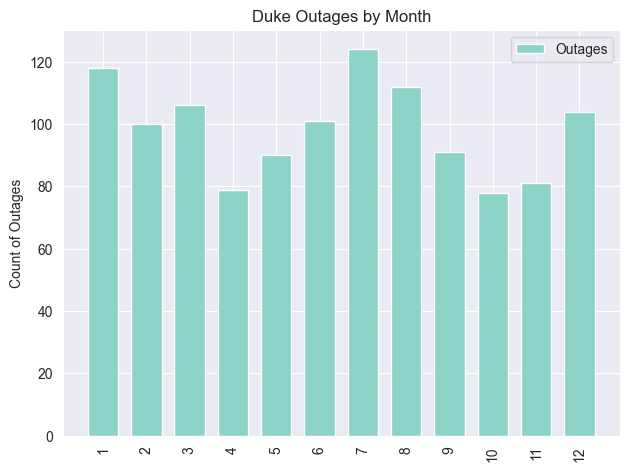

In [59]:
fig, ax = plt.subplots()

x = duke_month_outages_df["Outage Month"]
y = duke_month_outages_df["Event ID"]
width =0.7

rects1 = ax.bar(x, y, width, label = 'Outages')
ax.set_title('Duke Outages by Month')
ax.set_ylabel('Count of Outages')
ax.set_xticks(x)
ax.set_xticklabels(duke_month_outages_df["Outage Month"])
ax.legend()

fig.tight_layout()

plt.xticks(rotation=90)
plt.show()

### Source 5:
portalservice_power_units.json

In [70]:
with open(r'data/raw_data/portalservice_power_inspections_2022.json') as json_data:
    d = json.loads(json_data.read())
    json_data.close()

In [71]:
portalservice_power_inspections_2022_df = pd.json_normalize(d)

In [72]:
portalservice_power_inspections_2022_df.head(1)

,Inspection.id,Inspection.zero_offset,Inspection.show_excel,Inspection.target_release_time,Inspection.inspection_type,Inspection.sort_order,Inspection.ndt_method_type,Inspection.data_import,Inspection.name,Inspection.sales_robotic_service_id,Inspection.date,Inspection.component_id,Inspection.notes,Inspection.external_id,Inspection.slug,Inspection.demo,Inspection.read_only,Inspection.status,Inspection.job_id,Component.id,Component.tube_diameter,Component.tube_spacing,Component.sea_level,Component.shell_diameter,Component.slope_angle,Component.lat,Component.lng,Component.material_type,Component.wall_nominal_thickness,Component.wall_warning_thickness,Component.coating_nominal_thickness,Component.coating_warning_thickness,Component.component_type,Component.sales_asset_type_id,Component.alloy_id,Component.contents,Component.temperature,Component.difficulty_factor_percentage,Component.salesforce_id,Component.name,Component.description,Component.slug,Component.unit_id,Unit.id,Unit.description,Unit.built_date,Unit.fuel_type,Unit.inspection_code,Unit.retirement_date,Unit.sales_asset_category_id,Unit.salesforce_id,Unit.name,Unit.location_id,Unit.slug,Unit.capacity,Unit.inspection_interval_years,Unit.latitude,Unit.longitude,Unit.total_tubes,Job.id,Job.data_lead_id,Job.sales_rep_id,Job.supervisor_id,Job.ops_data_lead_id,Job.qa_qc_lead_id,Job.job_prep_opportunity_id,Job.location_id,Job.status,Job.start_date,Job.end_date,Job.slug,Location.id,Location.industry_type,Location.lat,Location.lng,Location.salesforce_id,Location.drive_folder_id,Location.name,Location.address_line_1,Location.address_line_2,Location.region,Location.postal_code,Location.country,Location.customer_id,Location.city,Location.slug,Location.slack_channel,Customer.id,Customer.logo,Customer.salesforce_id,Customer.drive_folder_id,Customer.name,Customer.slug
0,4060,None,1,None,wall_thickness,3241,ut,0,None,NaN,2022-12-08,208,,,20221208-a5eb08,0,0,completed,1392,208,2.0,3.0,NaN,NaN,None,None,None,carbon_steel,0.18,0.135,0.02,0.007,1,NaN,NaN,,ambient,0,None,Waterwalls,,waterwalls-320ab0,125,125,,None,,,None,NaN,,Unit 5,45,unit-5-49ecf3,0,0,0,0,0,1392,NaN,131.0,46.0,NaN,150.0,930,45,completed,2022-12-06,2022-12-07,job-609dac,45,power,40.41792,-86.91243,0011U00000EHUhKQAX,0B61E5R0McQ-1Zmt2cDVBaHZaTVE,Wade Utility Plant,403 Sheetz Street,,IN,47907,US,38,West Lafayette,wade-utility-plant-c9e652,insp_purdue_wade,38,customer_logos/purdue.png,0011U00000EHUhKQAX,0B61E5R0McQ-1Zmt2cDVBaHZaTVE,Purdue University,purdue-university-7a0ab8


In [73]:
portalservice_power_inspections_2022_df.columns

Index(['Inspection.id', 'Inspection.zero_offset', 'Inspection.show_excel',
       'Inspection.target_release_time', 'Inspection.inspection_type',
       'Inspection.sort_order', 'Inspection.ndt_method_type',
       'Inspection.data_import', 'Inspection.name',
       'Inspection.sales_robotic_service_id', 'Inspection.date',
       'Inspection.component_id', 'Inspection.notes', 'Inspection.external_id',
       'Inspection.slug', 'Inspection.demo', 'Inspection.read_only',
       'Inspection.status', 'Inspection.job_id', 'Component.id',
       'Component.tube_diameter', 'Component.tube_spacing',
       'Component.sea_level', 'Component.shell_diameter',
       'Component.slope_angle', 'Component.lat', 'Component.lng',
       'Component.material_type', 'Component.wall_nominal_thickness',
       'Component.wall_warning_thickness',
       'Component.coating_nominal_thickness',
       'Component.coating_warning_thickness', 'Component.component_type',
       'Component.sales_asset_type_id', 'Com

In [74]:
ref_df = portalservice_power_inspections_2022_df.loc[:,(
    'Inspection.slug',
    'Inspection.date',
    'Inspection.ndt_method_type',
    'Inspection.inspection_type',
    'Location.name',
    'Location.city',
    'Location.region',
    'Unit.id',
    'Unit.name',
    'Unit.slug',
    'Location.slack_channel',
    'Unit.retirement_date',
    'Component.tube_diameter', 
    'Component.tube_spacing',
    'Component.shell_diameter',
    'Unit.fuel_type',
    'Unit.capacity',
    'Unit.total_tubes',
    'Component.component_type',
    'Customer.name'
)]

In [75]:
ref_df.head(1)

,Inspection.slug,Inspection.date,Inspection.ndt_method_type,Inspection.inspection_type,Location.name,Location.city,Location.region,Unit.id,Unit.name,Unit.slug,Location.slack_channel,Unit.retirement_date,Component.tube_diameter,Component.tube_spacing,Component.shell_diameter,Unit.fuel_type,Unit.capacity,Unit.total_tubes,Component.component_type,Customer.name
0,20221208-a5eb08,2022-12-08,ut,wall_thickness,Wade Utility Plant,West Lafayette,IN,125,Unit 5,unit-5-49ecf3,insp_purdue_wade,None,2.0,3.0,NaN,,0,0,1,Purdue University


In [76]:
ref_df.shape

(266, 20)

In [77]:
set(ref_df['Component.component_type'])

{0, 1, 2, 3, 6}

In [78]:
ref_df[ref_df['Component.component_type']==0]

,Inspection.slug,Inspection.date,Inspection.ndt_method_type,Inspection.inspection_type,Location.name,Location.city,Location.region,Unit.id,Unit.name,Unit.slug,Location.slack_channel,Unit.retirement_date,Component.tube_diameter,Component.tube_spacing,Component.shell_diameter,Unit.fuel_type,Unit.capacity,Unit.total_tubes,Component.component_type,Customer.name
71,20220830-b7c5ee,2022-08-30,ut,wall_thickness,Southern Co - Plant Miller,Birmingham,,1181,Ammonia Tanks,ammonia-tanks-a216bb,,None,NaN,NaN,11.0,,0,0,0,Southern Co
72,20220830-7ba41a,2022-08-30,ut,wall_thickness,Southern Co - Plant Miller,Birmingham,,1181,Ammonia Tanks,ammonia-tanks-a216bb,,None,NaN,NaN,11.0,,0,0,0,Southern Co
73,20220830-466527,2022-08-30,ut,wall_thickness,Southern Co - Plant Miller,Birmingham,,1181,Ammonia Tanks,ammonia-tanks-a216bb,,None,NaN,NaN,11.0,,0,0,0,Southern Co
74,20220830-038419,2022-08-30,ut,wall_thickness,Southern Co - Plant Miller,Birmingham,,1181,Ammonia Tanks,ammonia-tanks-a216bb,,None,NaN,NaN,11.0,,0,0,0,Southern Co
75,20220830-825f94,2022-08-30,ut,wall_thickness,Southern Co - Plant Miller,Birmingham,,1181,Ammonia Tanks,ammonia-tanks-a216bb,,None,NaN,NaN,11.0,,0,0,0,Southern Co
76,20220830-a3bd00,2022-08-30,ut,wall_thickness,Southern Co - Plant Miller,Birmingham,,1181,Ammonia Tanks,ammonia-tanks-a216bb,,None,NaN,NaN,11.0,,0,0,0,Southern Co
78,20220822-15a1a0,2022-08-22,aut,wall_thickness,Evergy - La Cygne Power Station,La Cygne,KS,1630,Ammonia Tank A,ammonia-tank-a-c72a9a,,None,NaN,NaN,11.0,,0,0,0,Evergy
79,20220822-ae7793,2022-08-22,paut,wall_thickness,Evergy - La Cygne Power Station,La Cygne,KS,1630,Ammonia Tank A,ammonia-tank-a-c72a9a,,None,NaN,NaN,11.0,,0,0,0,Evergy
80,20220822-e09bc2,2022-08-22,aut,wall_thickness,Evergy - La Cygne Power Station,La Cygne,KS,1630,Ammonia Tank A,ammonia-tank-a-c72a9a,,None,NaN,NaN,11.0,,0,0,0,Evergy
81,20220822-9b6eda,2022-08-22,paut,wall_thickness,Evergy - La Cygne Power Station,La Cygne,KS,1630,Ammonia Tank A,ammonia-tank-a-c72a9a,,None,NaN,NaN,11.0,,0,0,0,Evergy


In [79]:
portalservice_power_inspections_2022_df.shape

(266, 93)

In [80]:
def get_only_boilers(df):
    """
    This util should filter the portalservice_power_inspections down to only boiler components
    """
    
    trim_df = df[
        (df['Inspection.ndt_method_type']=='ut') & 
        (df['Inspection.inspection_type']=='wall_thickness') &
        (df['Component.component_type'].isin([1,6]))]
    
    return trim_df

In [81]:
only_boilers_df = get_only_boilers(portalservice_power_inspections_2022_df)

In [82]:
only_boilers_df.shape

(123, 93)

In [83]:
clean_boiler_df = only_boilers_df.loc[:,(
    'Inspection.slug',
    'Inspection.date',
    'Inspection.ndt_method_type',
    'Inspection.inspection_type',
    'Component.tube_diameter', 
    'Component.tube_spacing',
    'Location.city',
    'Location.slug',
    'Unit.total_tubes',
    'Component.component_type',
    'Customer.name',
    'Component.wall_nominal_thickness'
)]

In [84]:
component_type_map = {
    1: 'boiler',
    2: 'tank shell',
    3: 'cone',
    4: 'floor',
    5: 'piping',
    6: 'panel'
}

In [85]:
clean_boiler_df.head()

,Inspection.slug,Inspection.date,Inspection.ndt_method_type,Inspection.inspection_type,Component.tube_diameter,Component.tube_spacing,Location.city,Location.slug,Unit.total_tubes,Component.component_type,Customer.name,Component.wall_nominal_thickness
0,20221208-a5eb08,2022-12-08,ut,wall_thickness,2.0,3.0,West Lafayette,wade-utility-plant-c9e652,0,1,Purdue University,0.18
8,20221116-e95eb3,2022-11-16,ut,wall_thickness,0.0,0.0,Petersburg,petersburg-b4d346,0,1,AES,0.25
11,20221111-263c77,2022-11-11,ut,wall_thickness,2.0,4.5,Petersburg,petersburg-b4d346,0,6,AES,0.24
12,20221111-177f5b,2022-11-11,ut,wall_thickness,2.0,2.5,Petersburg,petersburg-b4d346,0,1,AES,0.22
13,20221111-11f8b2,2022-11-11,ut,wall_thickness,2.0,4.5,Petersburg,petersburg-b4d346,0,6,AES,0.24


In [86]:
clean_boiler_df.shape

(123, 12)

In [87]:
clean_boiler_df.describe()

,Component.tube_diameter,Component.tube_spacing,Unit.total_tubes,Component.component_type,Component.wall_nominal_thickness
count,123.000000,123.000000,123.0,123.000000,115.000000
mean,1.262512,1.662602,0.0,1.284553,0.237565
std,1.214120,1.594463,0.0,1.163096,0.047859
min,0.000000,0.000000,0.0,1.000000,0.109000
25%,0.000000,0.000000,0.0,1.000000,0.203000
50%,1.500000,2.312500,0.0,1.000000,0.250000
75%,2.500000,3.000000,0.0,1.000000,0.250000
max,3.500000,5.375000,0.0,6.000000,0.385000


In [88]:
clean_boiler_df['Component.wall_nominal_thickness'].median()

0.25

In [89]:
clean_boiler_df['Component.wall_nominal_thickness'].isna().sum()

8

In [90]:
trim_inspslug_nom_df = clean_boiler_df.loc[:, ('Inspection.slug', 'Component.wall_nominal_thickness')]
trim_inspslug_nom_df.rename(columns={'Inspection.slug': 'slug',	'Component.wall_nominal_thickness': 'nominal'}, inplace=True)
median_nominal = trim_inspslug_nom_df['nominal'].median()
print('Nominal used to fillna:  {}'.format(median_nominal))
trim_inspslug_nom_df['nominal'].fillna(median_nominal, inplace=True)
trim_inspslug_nom_df.reset_index(inplace=True)

Nominal used to fillna:  0.25


In [91]:
trim_inspslug_nom_df.shape

(123, 3)

In [92]:
trim_inspslug_nom_df.head()

,index,slug,nominal
0,0,20221208-a5eb08,0.18
1,8,20221116-e95eb3,0.25
2,11,20221111-263c77,0.24
3,12,20221111-177f5b,0.22
4,13,20221111-11f8b2,0.24


In [93]:
inspection_slug = trim_inspslug_nom_df['slug'][1]

### Get actual inspection data

In [94]:
prod = {
    "url_start": "https://portal-service.cloud.geckorobotics.com/api/v1/deliverables/",
    "url_end": "/binned_plot_data.json", 
    "token": "eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6IkVpeTN0a0l0bzZ0SDFTZ1VZdUdXVCJ9.eyJpc3MiOiJodHRwczovL2dlY2tvcm9ib3RpY3MudXMuYXV0aDAuY29tLyIsInN1YiI6Imdvb2dsZS1vYXV0aDJ8MTAxODIxNjU3MzQ0ODI0ODQxMjA5IiwiYXVkIjpbImNsb3VkLmdlY2tvcm9ib3RpY3MuY29tIiwiaHR0cHM6Ly9nZWNrb3JvYm90aWNzLnVzLmF1dGgwLmNvbS91c2VyaW5mbyJdLCJpYXQiOjE2NzMzNjAzNTIsImV4cCI6MTY3MzQ0Njc1MiwiYXpwIjoiSm1la3lLS0RsM2liRzdQbExRY2JLWHZoekx1UTRaQ08iLCJzY29wZSI6Im9wZW5pZCBwcm9maWxlIGVtYWlsIiwicGVybWlzc2lvbnMiOlsiY29sbGVjdGlvbnM6M2RfbW9kZWxzOmVkaXQiLCJjb2xsZWN0aW9uczphZG5vYy1hYnUtZGhhYmktbmF0aW9uYWwtb2lsLWNvbXBhbnktMmE1MzY0OmVkaXQiLCJjb2xsZWN0aW9uczphZXAtYTgyZjE4OmVkaXQiLCJjb2xsZWN0aW9uczphZXMtZWE0ZjMwOmVkaXQiLCJjb2xsZWN0aW9uczpiYXNmLTBmMmNiZTplZGl0IiwiY29sbGVjdGlvbnM6Y2hldnJvbi0wMWE1M2Y6ZWRpdCIsImNvbGxlY3Rpb25zOmNvbWJpbmVkX2NvbXBvbmVudF9kZnM6ZWRpdCIsImNvbGxlY3Rpb25zOmRvbXRhci03NDVhNWE6ZWRpdCIsImNvbGxlY3Rpb25zOmR1a2UtN2YyZmFmOmVkaXQiLCJjb2xsZWN0aW9uczplYmVuc2J1cmctcG93ZXItY29tcGFueS0wZTEyMWY6ZWRpdCIsImNvbGxlY3Rpb25zOmV4eG9uLTdmZDJhYjplZGl0IiwiY29sbGVjdGlvbnM6ZmRlLWRlbW86ZWRpdCIsImNvbGxlY3Rpb25zOmdlb3JnaWEtcGFjaWZpYy1hMWVjNTM6ZWRpdCIsImNvbGxlY3Rpb25zOm1hbnVhbF9pbnNwZWN0aW9uczplZGl0IiwiY29sbGVjdGlvbnM6bm9uc3BlY2lmaWMtY3VzdG9tZXI6ZWRpdCIsImNvbGxlY3Rpb25zOnJvbGxvdXRfaW1hZ2VzOmVkaXQiLCJjb2xsZWN0aW9uczp1cy1uYXZ5LTY5YTcyYTplZGl0IiwiZ2Vja286cmVhZCIsImdlY2tvOnJvbG9kZXg6ZWRpdCJdfQ.OX8ynLTi6XF-SRjzbzrVfEnvVqYU2tFyRaoeyEKnq_YyxOlGAZoUPm1TxljS4EE7hcHM8HJqBHaYmk4gUH3bsnIjnG94z46HLMUb15v044QXVbzObOg78cB1ityCBDihaFssMxsK2TYjUmzXAAJ9TK2C4u7KgdPrYvGmOXkzPx-HgQHssc-5wBvZNawEWvCZkXyLOBF9Gnm5fWSHvimk__Vx_7iWjjLexQjaaVTgZfFGl3n6Brm7TQu-KCiK-pYy0EA1BEpgBeaNcjfrxw99Y-6eohDZvrC972kLQLZoDzwA3BOUtHBewZ8K2olbOS34v3WFmOlDW6II3boQqNcWBQ"
}

headers = {"accept": "application/json", "Authorization": f"Bearer {prod['token']}"}

print(f"Making Req...")
req = requests.get(f"{prod['url_start']}{inspection_slug}{prod['url_end']}", headers=headers)
#print(f"\tRequest Text: {req.text}")
print(f"...Req Done")

Making Req...
...Req Done


In [95]:
inspection_df = pd.DataFrame(req.json()['plots'][0]['data'])

In [96]:
inspection_df.head()

,plot_y,customer_x,x_bin,customer_y,y_bin,plot_x,thickness
0,0.0,14,14.0,0.0,0.0,14.0,0.26912
1,0.0,15,15.0,0.0,0.0,15.0,0.27956
2,0.0,17,17.0,0.0,0.0,17.0,0.26332
3,0.0,20,20.0,0.0,0.0,20.0,0.27724
4,0.0,21,21.0,0.0,0.0,21.0,0.28072


In [97]:
inspection_df.shape[0]

3048

In [98]:
inspection_df.customer_x.nunique()

200

In [99]:
inspection_df.plot_x.nunique()

200

OK so now we have an inspection df, lets group by tube # and get a min thickness for each tube, if min is less than .4*nominal then counter + 1 ... arrive at a number of at risk tubes per inspection ... turn that into a % of tubes at risk based on total tubes ?

In [100]:
def analyze_inspection_df(inspection_df, nominal, threshold):
    """
    Take inspection df return key stats
    input:
    inspection_df
    nominal - designed thickness, t at time 0
    threshold - target threshold for count (ie 40% of nominal => .4)
    output:
    min_t
    max_t
    ??? list of min_t's grouped by tube #
    count of tubes where min_t is < nominal
    """

    min_t = inspection_df.thickness.min()
    max_t = inspection_df.thickness.max()
    
    target = nominal*threshold
    
    tubes_inspected = inspection_df.customer_x.nunique()
    bins_collected = inspection_df.shape[0]

    min_t_by_tube_list = inspection_df.groupby(['customer_x'])['thickness'].min().to_list()
    
    ## NOTE: chnaged this to just be any, not grouped by tube above
    critical_tubes_count = len([t for t in min_t_by_tube_list if t < target])
    critical_bins_count = len([t for t in inspection_df.thickness if t < target])
    
    return min_t, max_t, tubes_inspected, bins_collected, critical_tubes_count, critical_bins_count

In [101]:
threshold = .4

In [102]:
targets_df = trim_inspslug_nom_df.head()

In [103]:
targets_df

,index,slug,nominal
0,0,20221208-a5eb08,0.18
1,8,20221116-e95eb3,0.25
2,11,20221111-263c77,0.24
3,12,20221111-177f5b,0.22
4,13,20221111-11f8b2,0.24


In [104]:
targets_df.shape

(5, 3)

In [105]:
def check_thickness(targets_df, threshold):
    """
    Takes a dataframe of target inspection slugs and nominals and returns analysis data
    inputs: targets_df, threshold
    outputs: analysis row, min,max,count critical
    """
    data_list = []
    error_slug_list = []

    for row in range(len(targets_df)):
        inspection_slug = targets_df.loc[row, 'slug']
        nominal = targets_df.loc[row, 'nominal']
        
        if row%10 == 0:
            print(row)

        req = requests.get(f"{prod['url_start']}{inspection_slug}{prod['url_end']}", headers=headers)
        if req.json():
            try:
                inspection_df = pd.DataFrame(req.json()['plots'][0]['data'])

                min_t, max_t, tubes_inspected, bins_collected, critical_tubes_count, critical_bins_count = analyze_inspection_df(inspection_df, nominal, threshold)

                data = [inspection_slug, nominal, min_t, max_t, tubes_inspected, bins_collected, critical_tubes_count, critical_bins_count]
                #print(data)
                data_list.append(data)
            except:
                print('error')
                error_slug_list.append(inspection_slug)
            
        else:
            print('Inspection slug failed to return data: {}'.format(inspection_slug))

            
    data_df = pd.DataFrame(data_list, columns=['slug', 'nominal', 'min_t', 'max_t', 'tubes_inspected', 'bins_collected', 'critical_tubes', 'critical_bins'])
    
    return data_df, error_slug_list

In [106]:
check_thickness(targets_df, threshold)

0


(              slug  nominal    min_t    max_t  tubes_inspected  \
 0  20221208-a5eb08     0.18  0.05916  0.22388               81   
 1  20221116-e95eb3     0.25  0.21576  0.32480              200   
 2  20221111-263c77     0.24  0.15428  0.31320               24   
 3  20221111-177f5b     0.22  0.11484  0.30624              309   
 4  20221111-11f8b2     0.24  0.15196  0.29928               24   
 
    bins_collected  critical_tubes  critical_bins  
 0           16344               1              1  
 1            3048               0              0  
 2            8719               0              0  
 3          106229               0              0  
 4           14354               0              0  ,
 [])

In [107]:
critical_df, error_slug_list = check_thickness(trim_inspslug_nom_df, threshold)

0
10
20
30
error
error
error
error
40
error
error
error
50
60
70
error
error
error
80
error
error
error
error
90
100
error
110
error
error
120


In [108]:
len(error_slug_list)

17

In [109]:
error_slug_list

['20220919-072202',
 '20220919-f40fdc',
 '20220919-35548d',
 '20220917-b520a5',
 '20220613-fee995',
 '20220523-493ffe',
 '20220515-77438d',
 '20220509-27e470',
 '20220509-addaf6',
 '20220509-0849bd',
 '20220507-caec3a',
 '20220507-182a26',
 '20220506-c90d1d',
 '20220506-396ef9',
 '20220419-492e00',
 '20220314-12b44e',
 '20220310-990386']

In [110]:
error_df = ref_df[ref_df['Inspection.slug'].isin(error_slug_list)]

In [111]:
error_df

,Inspection.slug,Inspection.date,Inspection.ndt_method_type,Inspection.inspection_type,Location.name,Location.city,Location.region,Unit.id,Unit.name,Unit.slug,Location.slack_channel,Unit.retirement_date,Component.tube_diameter,Component.tube_spacing,Component.shell_diameter,Unit.fuel_type,Unit.capacity,Unit.total_tubes,Component.component_type,Customer.name
66,20220919-072202,2022-09-19,ut,wall_thickness,Mt. Storm,Mt. Storm,WV,391,Unit 1,lower-slopes-41bae4,insp_dominion_mtstorm,None,1.750,2.3125,NaN,None,0,0,1,Dominion
67,20220919-f40fdc,2022-09-19,ut,wall_thickness,Mt. Storm,Mt. Storm,WV,391,Unit 1,lower-slopes-41bae4,insp_dominion_mtstorm,None,1.750,2.3125,NaN,None,0,0,1,Dominion
68,20220919-35548d,2022-09-19,ut,wall_thickness,Mt. Storm,Mt. Storm,WV,391,Unit 1,lower-slopes-41bae4,insp_dominion_mtstorm,None,1.750,2.3125,NaN,None,0,0,1,Dominion
69,20220917-b520a5,2022-09-17,ut,wall_thickness,Mt. Storm,Mt. Storm,WV,391,Unit 1,lower-slopes-41bae4,insp_dominion_mtstorm,None,1.750,2.3125,NaN,None,0,0,1,Dominion
120,20220613-fee995,2022-06-13,ut,wall_thickness,Warrick Power Station,Newburgh,IN,1460,Unit 4 Division Wall,unit-4-division-wall-eee651,insp_alcoa_warrick,None,2.969,3.0000,NaN,,0,0,1,ALCOA
124,20220523-493ffe,2022-05-23,ut,wall_thickness,Merom Generating Station,Sullivan,IN,29,Unit 1,unit-1-b4709b,insp_hoosier_energy_merom,None,2.750,3.2500,NaN,,0,0,1,Hallador Power Company
137,20220515-77438d,2022-05-15,ut,wall_thickness,AEP - Turk Power Station,Fulton,AR,1761,Boiler,boiler-dfb229,insp_aep_turk,None,0.000,0.0000,NaN,None,0,0,1,AEP
170,20220509-27e470,2022-05-09,ut,wall_thickness,Warrior Run,Cumberland,MD,22,Boiler 1,boiler-1-18ec02,insp_aes_warriorrun,None,1.500,2.6250,NaN,,0,0,1,AES
171,20220509-addaf6,2022-05-09,ut,wall_thickness,Warrior Run,Cumberland,MD,22,Boiler 1,boiler-1-18ec02,insp_aes_warriorrun,None,1.500,2.6250,NaN,,0,0,6,AES
172,20220509-0849bd,2022-05-09,ut,wall_thickness,Warrior Run,Cumberland,MD,22,Boiler 1,boiler-1-18ec02,insp_aes_warriorrun,None,1.500,2.6250,NaN,,0,0,6,AES


In [112]:
critical_df.shape

(106, 8)

In [113]:
critical_df.head()

,slug,nominal,min_t,max_t,tubes_inspected,bins_collected,critical_tubes,critical_bins
0,20221208-a5eb08,0.18,0.05916,0.22388,81,16344,1,1
1,20221116-e95eb3,0.25,0.21576,0.32480,200,3048,0,0
2,20221111-263c77,0.24,0.15428,0.31320,24,8719,0,0
3,20221111-177f5b,0.22,0.11484,0.30624,309,106229,0,0
4,20221111-11f8b2,0.24,0.15196,0.29928,24,14354,0,0


In [114]:
critical_df.tubes_inspected.sum()

16787

In [115]:
critical_df.critical_bins.sum()

3838

In [116]:
critical_df.critical_tubes.sum()

460

Percentage of inspected tubes with at least one critical thickness

In [117]:
100*(critical_df.critical_tubes.sum()/critical_df.tubes_inspected.sum())

2.7402156430571276

In [118]:
critical_df[critical_df['critical_bins'] != 0].shape

(13, 8)

In [119]:
critical_df.sort_values(by='critical_bins', ascending=False).head(20)

,slug,nominal,min_t,max_t,tubes_inspected,bins_collected,critical_tubes,critical_bins
15,20221011-7c7e5f,0.300,0.05916,0.39788,187,7572,103,1381
41,20220523-332ac6,0.385,0.07772,0.43732,187,9049,89,913
42,20220523-64417d,0.385,0.09396,0.36656,187,8554,97,509
14,20221011-18c8e9,0.280,0.05916,0.40716,187,7457,66,449
99,20220308-369097,0.303,0.09512,0.31436,37,1770,34,329
94,20220320-6f15b5,0.250,0.07076,0.24940,462,31318,37,170
85,20220422-bd7396,0.300,0.06496,0.31088,52,1198,16,51
39,20220613-df7704,0.250,0.08816,0.57304,159,9276,8,25
21,20221004-565f7b,0.250,0.08584,0.34452,589,14332,5,5
18,20221004-0fff48,0.240,0.08468,0.38860,88,11427,2,3


In [120]:
critical_df.head(1)

,slug,nominal,min_t,max_t,tubes_inspected,bins_collected,critical_tubes,critical_bins
0,20221208-a5eb08,0.18,0.05916,0.22388,81,16344,1,1


In [121]:
ref_df.head(1)

,Inspection.slug,Inspection.date,Inspection.ndt_method_type,Inspection.inspection_type,Location.name,Location.city,Location.region,Unit.id,Unit.name,Unit.slug,Location.slack_channel,Unit.retirement_date,Component.tube_diameter,Component.tube_spacing,Component.shell_diameter,Unit.fuel_type,Unit.capacity,Unit.total_tubes,Component.component_type,Customer.name
0,20221208-a5eb08,2022-12-08,ut,wall_thickness,Wade Utility Plant,West Lafayette,IN,125,Unit 5,unit-5-49ecf3,insp_purdue_wade,None,2.0,3.0,NaN,,0,0,1,Purdue University


In [122]:
comb_df = critical_df.merge(ref_df, how='left', left_on='slug', right_on='Inspection.slug')

In [123]:
comb_df.head()

,slug,nominal,min_t,max_t,tubes_inspected,bins_collected,critical_tubes,critical_bins,Inspection.slug,Inspection.date,Inspection.ndt_method_type,Inspection.inspection_type,Location.name,Location.city,Location.region,Unit.id,Unit.name,Unit.slug,Location.slack_channel,Unit.retirement_date,Component.tube_diameter,Component.tube_spacing,Component.shell_diameter,Unit.fuel_type,Unit.capacity,Unit.total_tubes,Component.component_type,Customer.name
0,20221208-a5eb08,0.18,0.05916,0.22388,81,16344,1,1,20221208-a5eb08,2022-12-08,ut,wall_thickness,Wade Utility Plant,West Lafayette,IN,125,Unit 5,unit-5-49ecf3,insp_purdue_wade,None,2.0,3.0,NaN,,0,0,1,Purdue University
1,20221116-e95eb3,0.25,0.21576,0.32480,200,3048,0,0,20221116-e95eb3,2022-11-16,ut,wall_thickness,Petersburg,Petersburg,IN,500,Boiler U3,unit-3-e43a85,insp_aes_petersburg,None,0.0,0.0,NaN,,0,0,1,AES
2,20221111-263c77,0.24,0.15428,0.31320,24,8719,0,0,20221111-263c77,2022-11-11,ut,wall_thickness,Petersburg,Petersburg,IN,500,Boiler U3,unit-3-e43a85,insp_aes_petersburg,None,2.0,4.5,NaN,,0,0,6,AES
3,20221111-177f5b,0.22,0.11484,0.30624,309,106229,0,0,20221111-177f5b,2022-11-11,ut,wall_thickness,Petersburg,Petersburg,IN,500,Boiler U3,unit-3-e43a85,insp_aes_petersburg,None,2.0,2.5,NaN,,0,0,1,AES
4,20221111-11f8b2,0.24,0.15196,0.29928,24,14354,0,0,20221111-11f8b2,2022-11-11,ut,wall_thickness,Petersburg,Petersburg,IN,500,Boiler U3,unit-3-e43a85,insp_aes_petersburg,None,2.0,4.5,NaN,,0,0,6,AES


In [124]:
comb_df.iloc[0,0][4:6]

'12'

In [125]:
set(comb_df['Customer.name'])

{'AEP',
 'AES',
 'ALCOA',
 'Consolidated Edison Company of New York (Corporate)',
 'Covanta',
 'Dominion',
 'Duke Energy',
 'East Kentucky Power Coop (EKPC)',
 'Ebensburg Power Company',
 'Great River Energy',
 'Hallador Power Company',
 'Ingredion, Inc.',
 'JEA',
 'Koch Industries (Corporate)',
 'LG&E',
 'Lower Colorado River Authority',
 'NRG',
 'Purdue University',
 'Southern Co',
 'Southern Illinois Power Cooperative',
 'Stonghold Digital Mining',
 'Sunflower Electric Power Corp',
 'University of North Carolina (UNC)'}

In [126]:
def group_critdat(comb_df, groupon_list):
    """
    Takes the comb_df and a groupon_list and returns a sorted, grouped df
    """
    
    crits_df = comb_df.groupby(groupon_list)['tubes_inspected',	'bins_collected', 'critical_tubes', 'critical_bins'].sum().reset_index()
    count_df = comb_df.groupby(groupon_list)['slug'].nunique().to_frame().reset_index()
    
    merged_df = count_df.merge(crits_df, how='outer', on=groupon_list)
    merged_df.rename(columns={'slug': 'inspections'}, inplace=True)
    
    return merged_df

In [127]:
group_critdat(comb_df, ['Customer.name']).sort_values(by='critical_bins', ascending=False)

,Customer.name,inspections,tubes_inspected,bins_collected,critical_tubes,critical_bins
10,Hallador Power Company,4,748,32632,355,3252
4,Covanta,4,256,6217,50,380
9,Great River Energy,9,1800,72280,37,170
2,ALCOA,4,382,14030,8,25
6,Duke Energy,2,767,24519,5,5
8,Ebensburg Power Company,4,132,17879,2,3
21,Sunflower Electric Power Corp,4,511,39297,1,1
1,AES,13,2200,336719,1,1
17,Purdue University,1,81,16344,1,1
0,AEP,28,1132,74759,0,0


In [128]:
group_critdat(comb_df, ['Customer.name', 'Unit.id']).sort_values(by='critical_bins', ascending=False)

,Customer.name,Unit.id,inspections,tubes_inspected,bins_collected,critical_tubes,critical_bins
25,Hallador Power Company,63,2,374,15029,169,1830
24,Hallador Power Company,29,2,374,17603,186,1422
10,Covanta,1707,2,74,2703,34,329
19,Great River Energy,217,1,462,31318,37,170
11,Covanta,1740,1,52,1198,16,51
7,ALCOA,1831,2,374,13963,8,25
15,Duke Energy,1943,2,767,24519,5,5
17,Ebensburg Power Company,51,4,132,17879,2,3
2,AES,22,5,557,56825,1,1
42,Sunflower Electric Power Corp,1903,2,233,5590,1,1


In [129]:
group_critdat(comb_df, ['Location.region', 'Customer.name', 'Location.city', 'Unit.id']).sort_values(by='critical_bins', ascending=False)

,Location.region,Customer.name,Location.city,Unit.id,inspections,tubes_inspected,bins_collected,critical_tubes,critical_bins
22,IN,Hallador Power Company,Sullivan,63,2,374,15029,169,1830
21,IN,Hallador Power Company,Sullivan,29,2,374,17603,186,1422
37,OK,Covanta,Tulsa,1707,2,74,2703,34,329
36,ND,Great River Energy,Underwood,217,1,462,31318,37,170
38,OK,Covanta,Tulsa,1740,1,52,1198,16,51
20,IN,ALCOA,Newburgh,1831,2,374,13963,8,25
3,,Duke Energy,Owensville,1943,2,767,24519,5,5
40,PA,Ebensburg Power Company,Ebensburg,51,4,132,17879,2,3
28,MD,AES,Cumberland,22,5,557,56825,1,1
25,KS,Sunflower Electric Power Corp,Hays,1903,2,233,5590,1,1


In [130]:
loc_crits_df = comb_df.groupby(['Location.region'])['tubes_inspected', 'bins_collected', 'critical_tubes', 'critical_bins'].sum().reset_index()
loc_count_df = comb_df.groupby(['Location.region'])['slug'].nunique().to_frame().reset_index()

loc_merged_df = loc_count_df.merge(loc_crits_df, how='outer', on=['Location.region'])
loc_merged_df.sort_values(by='critical_bins', ascending=False).rename(columns={'slug': 'inspections'})

,Location.region,inspections,tubes_inspected,bins_collected,critical_tubes,critical_bins
5,IN,16,2617,333678,364,3278
11,OK,4,256,6217,50,380
10,ND,9,1800,72280,37,170
0,,17,5168,436027,5,5
12,PA,6,279,36326,2,3
6,KS,3,329,18440,1,1
8,MD,5,557,56825,1,1
1,AR,29,1139,41234,0,0
2,CA,1,237,9222,0,0
3,GA,4,1074,178827,0,0


In [131]:
portalservice_power_inspections_2022_df[portalservice_power_inspections_2022_df['Customer.name']=='Hallador Power Company']

,Inspection.id,Inspection.zero_offset,Inspection.show_excel,Inspection.target_release_time,Inspection.inspection_type,Inspection.sort_order,Inspection.ndt_method_type,Inspection.data_import,Inspection.name,Inspection.sales_robotic_service_id,Inspection.date,Inspection.component_id,Inspection.notes,Inspection.external_id,Inspection.slug,Inspection.demo,Inspection.read_only,Inspection.status,Inspection.job_id,Component.id,Component.tube_diameter,Component.tube_spacing,Component.sea_level,Component.shell_diameter,Component.slope_angle,Component.lat,Component.lng,Component.material_type,Component.wall_nominal_thickness,Component.wall_warning_thickness,Component.coating_nominal_thickness,Component.coating_warning_thickness,Component.component_type,Component.sales_asset_type_id,Component.alloy_id,Component.contents,Component.temperature,Component.difficulty_factor_percentage,Component.salesforce_id,Component.name,Component.description,Component.slug,Component.unit_id,Unit.id,Unit.description,Unit.built_date,Unit.fuel_type,Unit.inspection_code,Unit.retirement_date,Unit.sales_asset_category_id,Unit.salesforce_id,Unit.name,Unit.location_id,Unit.slug,Unit.capacity,Unit.inspection_interval_years,Unit.latitude,Unit.longitude,Unit.total_tubes,Job.id,Job.data_lead_id,Job.sales_rep_id,Job.supervisor_id,Job.ops_data_lead_id,Job.qa_qc_lead_id,Job.job_prep_opportunity_id,Job.location_id,Job.status,Job.start_date,Job.end_date,Job.slug,Location.id,Location.industry_type,Location.lat,Location.lng,Location.salesforce_id,Location.drive_folder_id,Location.name,Location.address_line_1,Location.address_line_2,Location.region,Location.postal_code,Location.country,Location.customer_id,Location.city,Location.slug,Location.slack_channel,Customer.id,Customer.logo,Customer.salesforce_id,Customer.drive_folder_id,Customer.name,Customer.slug
41,3951,None,1,None,wall_thickness,3122,ut,0,None,NaN,2022-10-11,87,,,20221011-18c8e9,0,0,completed,1226,87,2.75,3.25,NaN,NaN,None,None,None,carbon_steel,0.280,0.16,0.0,0.0,1,NaN,NaN,None,,0,,Left Wall,,right-wall-4ee870,63,63,,None,,,None,NaN,,Unit 2,11,unit-2-cc04f4,0,0,0,0,0,1226,NaN,NaN,46.0,NaN,150.0,782,11,completed,2022-10-12,2022-10-13,job-36651b,11,power,39.053237,-87.306205,0011U00000EHUfAQAX,1n5ZkMEVuEUIsOiH9iS-_9r7SQYBZOnyr,Merom Generating Station,5500 W Co Rd 200 S,,IN,47882,US,11,Sullivan,merom-generating-station-cd844e,insp_hoosier_energy_merom,11,customer_logos/8005a34eb60cb45932e02916030fe90...,0011U00000EHUfAQAX,0B61E5R0McQ-1d3QzTnN0SDh4U2c,Hallador Power Company,hoosier-energy-663a11
42,3952,None,1,None,wall_thickness,3123,ut,0,None,NaN,2022-10-11,88,,,20221011-7c7e5f,0,0,completed,1226,88,2.75,3.25,NaN,NaN,None,None,None,carbon_steel,0.300,0.18,0.0,0.0,1,NaN,NaN,None,,0,,Right Wall,,left-wall-016813,63,63,,None,,,None,NaN,,Unit 2,11,unit-2-cc04f4,0,0,0,0,0,1226,NaN,NaN,46.0,NaN,150.0,782,11,completed,2022-10-12,2022-10-13,job-36651b,11,power,39.053237,-87.306205,0011U00000EHUfAQAX,1n5ZkMEVuEUIsOiH9iS-_9r7SQYBZOnyr,Merom Generating Station,5500 W Co Rd 200 S,,IN,47882,US,11,Sullivan,merom-generating-station-cd844e,insp_hoosier_energy_merom,11,customer_logos/8005a34eb60cb45932e02916030fe90...,0011U00000EHUfAQAX,0B61E5R0McQ-1d3QzTnN0SDh4U2c,Hallador Power Company,hoosier-energy-663a11
124,3603,None,0,None,wall_thickness,2819,ut,0,None,NaN,2022-05-23,29,,,20220523-493ffe,0,0,completed,1149,29,2.75,3.25,546.75,NaN,None,None,None,carbon_steel,0.350,0.13,0.0,0.0,1,NaN,NaN,,ambient,0,None,Waterwalls,,waterwalls-ca4fd0,29,29,,None,,,None,NaN,,Unit 1,11,unit-1-b4709b,0,0,0,0,0,1149,NaN,220.0,505.0,NaN,150.0,624,11,completed,2022-05-23,2022-05-24,job-16126d,11,power,39.053237,-87.306205,0011U00000EHUfAQAX,1n5ZkMEVuEUIsOiH9iS-_9r7SQYBZOnyr,Merom Generating Station,5500 W Co Rd 200 S,,IN,47882,US,11,Sullivan,merom-generating-station-cd844e,insp_hoosier_energy_merom,11,customer_logos/8005a34eb60cb45932e02916030fe90...,0011U00000EHUfAQAX,0B61E5R0McQ-1d3QzTnN0SDh4U2c,Hallador Power Company,hoosier-energy-663a11
125,361

In [132]:
with open(r'data/raw_data/portalservice_power_units.json') as json_data:
    d = json.loads(json_data.read())
    json_data.close()

In [133]:
portalservice_power_units_df = pd.json_normalize(d)

In [134]:
portalservice_power_units_df.head()

,Unit.id,Unit.description,Unit.built_date,Unit.fuel_type,Unit.inspection_code,Unit.retirement_date,Unit.sales_asset_category_id,Unit.salesforce_id,Unit.name,Unit.location_id,Unit.slug,Unit.capacity,Unit.inspection_interval_years,Unit.latitude,Unit.longitude,Unit.total_tubes,Location.id,Location.industry_type,Location.lat,Location.lng,Location.salesforce_id,Location.drive_folder_id,Location.name,Location.address_line_1,Location.address_line_2,Location.region,Location.postal_code,Location.country,Location.customer_id,Location.city,Location.slug,Location.slack_channel,Customer.id,Customer.logo,Customer.salesforce_id,Customer.drive_folder_id,Customer.name,Customer.slug
0,1,,None,,,None,1.0,02i1U0000028OlBQAU,Boiler 7,1,boiler-7-224f9b,0.0,5.0,0.0,0.0,0,1,power,35.93186,-79.05664,0011U00000EHUiBQAX,1arv_O9YoN9UyZ0s7J_fbazQzoHvtKkOo,Chapel Hill,104 Airport Dr.,,NC,27599,US,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
1,5,,None,None,None,None,1.0,02i1U0000028Ol6QAE,Boiler 6 - 2016,1,boiler-6-0f5b4b,0.0,5.0,0.0,0.0,0,1,power,35.93186,-79.05664,0011U00000EHUiBQAX,1arv_O9YoN9UyZ0s7J_fbazQzoHvtKkOo,Chapel Hill,104 Airport Dr.,,NC,27599,US,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
2,1738,,None,None,None,None,1.0,None,Boiler 6,1,boiler-6-21a474,0.0,0.0,0.0,0.0,0,1,power,35.93186,-79.05664,0011U00000EHUiBQAX,1arv_O9YoN9UyZ0s7J_fbazQzoHvtKkOo,Chapel Hill,104 Airport Dr.,,NC,27599,US,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
3,1796,,None,None,None,None,NaN,None,Boiler 7 - 2016,1,boiler-7-2016-5a769f,0.0,0.0,0.0,0.0,0,1,power,35.93186,-79.05664,0011U00000EHUiBQAX,1arv_O9YoN9UyZ0s7J_fbazQzoHvtKkOo,Chapel Hill,104 Airport Dr.,,NC,27599,US,1,Chapel Hill,chapel-hill-c2e4a9,insp_unc_chapel_hill,1,customer_logos/unc.png,0011U00000EHUiBQAX,1I-20Q-1dq9fRwL4LwfyNrrEETxou0zHUrIReGIQ,University of North Carolina (UNC),university-of-north-carolina-unc-a6d188
4,2,,None,,,None,NaN,,Boiler 1,2,boiler-1-4fb4ce,0.0,0.0,0.0,0.0,0,2,power,30.27082,-93.29602,0011U00001JVH1QQAX,11tzBL7_TvWL6yRnsPvkqJlTkda2-OzVb,Westlake,3400 Houston River Road,,LA,70669,US,2,Westlake,westlake-438042,,2,customer_logos/nisco.png,0011U00001JVH1QQAX,1tt5XBaYFsL15dNBkQJAsZeYRdilVGAAs,NISCO,nisco-7b0507


In [135]:
portalservice_power_units_df.shape

(780, 38)

In [136]:
portalservice_power_units_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unit.id                         780 non-null    int64  
 1   Unit.description                719 non-null    object 
 2   Unit.built_date                 23 non-null     object 
 3   Unit.fuel_type                  606 non-null    object 
 4   Unit.inspection_code            602 non-null    object 
 5   Unit.retirement_date            4 non-null      object 
 6   Unit.sales_asset_category_id    239 non-null    float64
 7   Unit.salesforce_id              623 non-null    object 
 8   Unit.name                       780 non-null    object 
 9   Unit.location_id                780 non-null    int64  
 10  Unit.slug                       780 non-null    object 
 11  Unit.capacity                   780 non-null    float64
 12  Unit.inspection_interval_years  780 

### Ideas to filter for just boilers:

- boiler in name or slug
- unit name or slug
- drop anything with silo or bunker in the name or slug
- contains econo or eva
- drop anything with tank

In [137]:
portalservice_power_units_df.loc[:, ('Unit.name', 'Unit.slug')].head(10)

,Unit.name,Unit.slug
0,Boiler 7,boiler-7-224f9b
1,Boiler 6 - 2016,boiler-6-0f5b4b
2,Boiler 6,boiler-6-21a474
3,Boiler 7 - 2016,boiler-7-2016-5a769f
4,Boiler 1,boiler-1-4fb4ce
5,Boiler 1,boiler-1-e96665
6,Boiler 10,boiler-10-7055ca
7,49I03 IXB Cation,anion-tanks-5be568
8,49I04 IWB Anion,anion-tank-2-b308e8
9,49I05 IXC Cation,anion-tank-3-916d1b


In [138]:
portalservice_power_units_df.describe()

,Unit.id,Unit.sales_asset_category_id,Unit.location_id,Unit.capacity,Unit.inspection_interval_years,Unit.latitude,Unit.longitude,Unit.total_tubes,Location.id,Location.lat,Location.lng,Location.customer_id,Customer.id
count,780.000000,239.000000,780.000000,780.000000,780.000000,780.000000,7.800000e+02,780.000000,780.000000,774.000000,774.000000,780.00000,780.00000
mean,998.507692,5.891213,239.164103,3.284487,0.148397,0.687801,-1.024765e+13,3.693590,239.164103,35.429891,-83.376395,106.49359,106.49359
std,647.343142,3.275303,225.016237,29.721559,0.909327,5.930977,2.862012e+14,73.043042,225.016237,13.961600,36.568314,107.72840,107.72840
min,1.000000,1.000000,1.000000,0.000000,0.000000,-23.830503,-7.993163e+15,0.000000,1.000000,-33.437220,-158.129097,1.00000,1.00000
25%,427.500000,4.000000,55.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,55.000000,33.665995,-97.399950,20.00000,20.00000
50%,969.500000,5.000000,149.500000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,149.500000,38.523460,-87.306205,86.50000,86.50000
75%,1554.750000,9.000000,369.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,369.000000,40.768470,-80.065280,152.00000,152.00000
max,2152.000000,15.000000,886.000000,500.000000,10.000000,61.107582,1.511512e+02,1918.000000,886.000000,61.107500,151.244200,480.00000,480.00000


In [139]:
aep_month_outage_df.head()

,Outage Month,Event Start Timestamp
0,1,158
1,2,93
2,3,116
3,4,91
4,5,105


In [140]:
duke_month_outages_df.head()

,Outage Month,Event ID
0,1,118
1,2,100
2,3,106
3,4,79
4,5,90


In [141]:
aep_month_outage_df.rename(columns={'Event Start Timestamp': 'Event Count'}, inplace=True)
duke_month_outages_df.rename(columns={'Event ID': 'Event Count'}, inplace=True)
aep_month_outage_df['Utility'] = 'AEP'
duke_month_outages_df['Utility'] = 'Duke'

In [142]:
eia_df = pd.read_csv(r'data/raw_data/EIA.csv')

In [143]:
eia_df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,FFPRBUS,194913,28.740479,1,Total Fossil Fuels Production,Quadrillion Btu
1,FFPRBUS,195013,32.553205,1,Total Fossil Fuels Production,Quadrillion Btu
2,FFPRBUS,195113,35.782118,1,Total Fossil Fuels Production,Quadrillion Btu
3,FFPRBUS,195213,34.964662,1,Total Fossil Fuels Production,Quadrillion Btu
4,FFPRBUS,195313,35.338361,1,Total Fossil Fuels Production,Quadrillion Btu


In [144]:
eia_df.shape

(8040, 6)

In [145]:
eia_df['Year'] = eia_df['YYYYMM'].astype(str).str[0:4]
eia_df['Month'] = eia_df['YYYYMM'].astype(str).str[4:6]

In [146]:
set(eia_df['Month'])

{'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13'}

In [147]:
recent_eia_df = eia_df[eia_df['Year'].astype(int) > 2000]

In [148]:
recent_eia_df.shape

(3384, 8)

In [149]:
set(recent_eia_df['Month'])

{'01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13'}

In [150]:
set(recent_eia_df["Description"])

{'Nuclear Electric Power Consumption',
 'Nuclear Electric Power Production',
 'Primary Energy Exports',
 'Primary Energy Imports',
 'Primary Energy Net Imports',
 'Primary Energy Stock Change and Other',
 'Total Fossil Fuels Consumption',
 'Total Fossil Fuels Production',
 'Total Primary Energy Consumption',
 'Total Primary Energy Production',
 'Total Renewable Energy Consumption',
 'Total Renewable Energy Production'}

In [151]:
keep_cols = ['Total Primary Energy Consumption',
 'Total Primary Energy Production']

In [152]:
eia_prim_en_df = recent_eia_df[recent_eia_df["Description"].isin(keep_cols)]

In [153]:
eia_prim_en_df.shape

(564, 8)

In [154]:
eia_prim_en_df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit,Year,Month
2398,TEPRBUS,200101,6.109594,4,Total Primary Energy Production,Quadrillion Btu,2001,01
2399,TEPRBUS,200102,5.530608,4,Total Primary Energy Production,Quadrillion Btu,2001,02
2400,TEPRBUS,200103,6.180135,4,Total Primary Energy Production,Quadrillion Btu,2001,03
2401,TEPRBUS,200104,5.791105,4,Total Primary Energy Production,Quadrillion Btu,2001,04
2402,TEPRBUS,200105,6.063600,4,Total Primary Energy Production,Quadrillion Btu,2001,05


In [155]:
eia_2021_df = eia_prim_en_df[(eia_prim_en_df['Year']=='2021') & (eia_prim_en_df['Month']!='13')]

In [156]:
eia_2021_df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit,Year,Month
2658,TEPRBUS,202101,8.252314,4,Total Primary Energy Production,Quadrillion Btu,2021,01
2659,TEPRBUS,202102,6.861249,4,Total Primary Energy Production,Quadrillion Btu,2021,02
2660,TEPRBUS,202103,8.365773,4,Total Primary Energy Production,Quadrillion Btu,2021,03
2661,TEPRBUS,202104,8.018633,4,Total Primary Energy Production,Quadrillion Btu,2021,04
2662,TEPRBUS,202105,8.400430,4,Total Primary Energy Production,Quadrillion Btu,2021,05


In [157]:
eia_2021_consumption = eia_2021_df[eia_2021_df['Description']=='Total Primary Energy Consumption']
eia_2021_production = eia_2021_df[eia_2021_df['Description']=='Total Primary Energy Production']

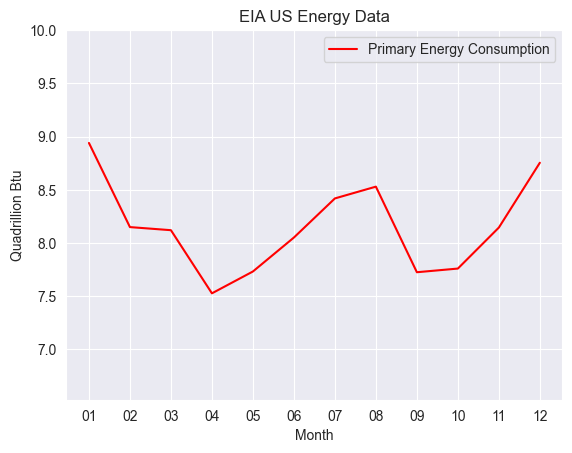

In [158]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

ax.set_title('EIA US Energy Data')
ax.set_ylabel('Quadrillion Btu')
ax.set_ylim(eia_2021_consumption['Value'].min()-1,10)
ax.set_xlabel('Month')
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(eia_2021_consumption['Month'])


ax.plot(eia_2021_consumption['Month'].astype(int), eia_2021_consumption['Value'], c='r', label='Primary Energy Consumption')
#ax.plot(eia_2021_production['Month'].astype(int), eia_2021_production['Value'], c='g', label='Primary Energy Production')


plt.legend()
plt.draw()

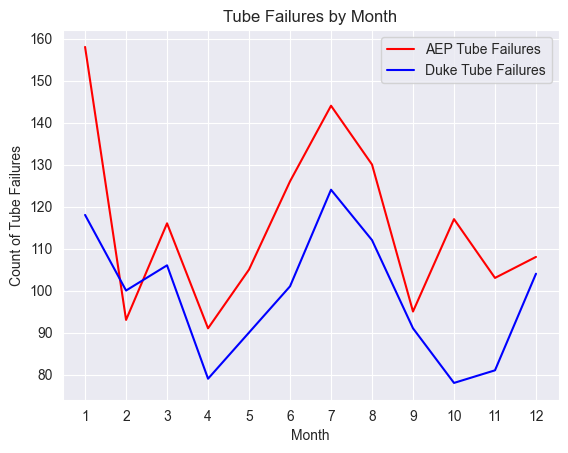

In [159]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

ax.set_title('Tube Failures by Month')
ax.set_ylabel('Count of Tube Failures')
ax.set_xlabel('Month')
ax.set_xticks(aep_month_outage_df['Outage Month'])
ax.set_xticklabels(aep_month_outage_df['Outage Month'])


ax.plot(aep_month_outage_df['Outage Month'], aep_month_outage_df['Event Count'], c='r', label='AEP Tube Failures')
ax.plot(duke_month_outages_df['Outage Month'], duke_month_outages_df['Event Count'], c='b', label='Duke Tube Failures')


plt.legend()
plt.draw()

In [160]:
comb_df.head()

,slug,nominal,min_t,max_t,tubes_inspected,bins_collected,critical_tubes,critical_bins,Inspection.slug,Inspection.date,Inspection.ndt_method_type,Inspection.inspection_type,Location.name,Location.city,Location.region,Unit.id,Unit.name,Unit.slug,Location.slack_channel,Unit.retirement_date,Component.tube_diameter,Component.tube_spacing,Component.shell_diameter,Unit.fuel_type,Unit.capacity,Unit.total_tubes,Component.component_type,Customer.name
0,20221208-a5eb08,0.18,0.05916,0.22388,81,16344,1,1,20221208-a5eb08,2022-12-08,ut,wall_thickness,Wade Utility Plant,West Lafayette,IN,125,Unit 5,unit-5-49ecf3,insp_purdue_wade,None,2.0,3.0,NaN,,0,0,1,Purdue University
1,20221116-e95eb3,0.25,0.21576,0.32480,200,3048,0,0,20221116-e95eb3,2022-11-16,ut,wall_thickness,Petersburg,Petersburg,IN,500,Boiler U3,unit-3-e43a85,insp_aes_petersburg,None,0.0,0.0,NaN,,0,0,1,AES
2,20221111-263c77,0.24,0.15428,0.31320,24,8719,0,0,20221111-263c77,2022-11-11,ut,wall_thickness,Petersburg,Petersburg,IN,500,Boiler U3,unit-3-e43a85,insp_aes_petersburg,None,2.0,4.5,NaN,,0,0,6,AES
3,20221111-177f5b,0.22,0.11484,0.30624,309,106229,0,0,20221111-177f5b,2022-11-11,ut,wall_thickness,Petersburg,Petersburg,IN,500,Boiler U3,unit-3-e43a85,insp_aes_petersburg,None,2.0,2.5,NaN,,0,0,1,AES
4,20221111-11f8b2,0.24,0.15196,0.29928,24,14354,0,0,20221111-11f8b2,2022-11-11,ut,wall_thickness,Petersburg,Petersburg,IN,500,Boiler U3,unit-3-e43a85,insp_aes_petersburg,None,2.0,4.5,NaN,,0,0,6,AES


In [161]:
comb_df['Inspection.month'] = pd.to_datetime(comb_df['Inspection.date']).dt.month

In [162]:
set(comb_df['Inspection.month'])

{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [163]:
gecko_2022_inspections = comb_df.groupby(['Inspection.month'])['slug'].nunique().to_frame().reset_index().rename(columns={'slug': 'inspections'})

In [164]:
gecko_2022_inspections

,Inspection.month,inspections
0,1,5
1,3,12
2,4,4
3,5,44
4,6,2
5,7,2
6,8,5
7,9,6
8,10,14
9,11,11


In [165]:
gecko_2022_inspections['inspections'].sum()

106

In [166]:
#us_boilers_df.loc[:, ('MARKET_REG', 'PLANT_NAME')]

In [167]:
us_boilers_df.loc[:, ('MARKET_REG', 'UNIT_STATE')]

,MARKET_REG,UNIT_STATE
0,Great Lakes,OH
1,Mid Atlantic,WV
2,Southeast,TN
3,Southeast,TN
4,Great Lakes,OH
...,...,...
2533,Great Lakes,IL
2534,Rocky Mountains,CO
2535,Rocky Mountains,CO
2536,West Coast,HI


In [168]:
len(comb_df['Location.city'])

106

In [169]:
len([city for city in comb_df['Location.city'] if city not in us_boilers_df['PHYS_CITY']])

106

In [170]:
set(us_boilers_df['MARKET_REG'])

{'Atlantic Canada',
 'Great Lakes',
 'Mid Atlantic',
 'Midwest',
 'New England',
 'Northeast',
 'Ontario',
 'Rocky Mountains',
 'Southeast',
 'Southwest',
 'West Coast',
 'Western Canada'}

In [171]:
markets_comb_df = comb_df.merge(us_boilers_df.loc[:, ('MARKET_REG', 'UNIT_STATE')], how='left', left_on='Location.region', right_on='UNIT_STATE')

In [172]:
markets_comb_df.groupby(['MARKET_REG'])['Unit.slug'].nunique().to_frame()

,Unit.slug
MARKET_REG,
Great Lakes,10
Mid Atlantic,4
Midwest,8
Northeast,3
Southeast,2
Southwest,7
West Coast,1


In [173]:
market_aggs = group_critdat(markets_comb_df, ['MARKET_REG']).sort_values(by='critical_bins', ascending=False)

In [174]:
market_aggs['percent_of_tubes_critical'] = 100*market_aggs['critical_tubes']/market_aggs['tubes_inspected']
market_aggs['percent_of_bins_critical'] = 100*market_aggs['critical_bins']/market_aggs['bins_collected']


In [175]:
market_aggs

,MARKET_REG,inspections,tubes_inspected,bins_collected,critical_tubes,critical_bins,percent_of_tubes_critical,percent_of_bins_critical
0,Great Lakes,23,407643,44734563,40768,367136,10.000908,0.820699
5,Southwest,34,80750,9127926,2450,18620,3.034056,0.203989
2,Midwest,12,38689,1767960,559,2421,1.444855,0.136937
3,Northeast,6,32085,4177490,230,345,0.716846,0.008259
1,Mid Atlantic,9,95652,6494052,28,28,0.029273,0.000431
4,Southeast,4,53700,8941350,0,0,0.000000,0.000000
6,West Coast,1,30810,1198860,0,0,0.000000,0.000000


In [176]:
market_unit_aggs = group_critdat(markets_comb_df, ['MARKET_REG', 'Unit.name']).sort_values(by='critical_bins', ascending=False)

In [177]:
market_unit_aggs['percent_of_tubes_critical'] = 100*market_unit_aggs['critical_tubes']/market_unit_aggs['tubes_inspected']

In [178]:
market_unit_aggs.head(10)

,MARKET_REG,Unit.name,inspections,tubes_inspected,bins_collected,critical_tubes,critical_bins,percent_of_tubes_critical
5,Great Lakes,Unit 2,2,41888,1683248,18928,204960,45.187166
4,Great Lakes,Unit 1,5,77861,3640784,20832,159264,26.755372
28,Southwest,Unit 3,3,45635,8007358,1666,16121,3.650707
7,Great Lakes,Unit 4 Boiler,2,41888,1563856,896,2800,2.139037
27,Southwest,Unit 2,2,4940,105622,784,2499,15.870445
19,Midwest,Unit 2,1,6468,438452,518,2380,8.008658
21,Northeast,Unit 1,5,23690,3109715,230,345,0.970874
8,Great Lakes,Unit 5,1,9072,1830528,112,112,1.234568
20,Midwest,Unit FD4,2,9553,229190,41,41,0.429185
9,Mid Atlantic,Boiler 1,5,15596,1591100,28,28,0.179533


In [179]:
market_unit_aggs[market_unit_aggs['percent_of_tubes_critical']!=0].shape[0]

10

In [180]:
market_unit_aggs.shape[0]

30

In [181]:
units_inspected_bycust = comb_df.groupby(['Customer.name'])['Unit.slug'].nunique().to_frame().reset_index()

In [182]:
units_inspected_bycust['Unit.slug'].sum()

45

In [183]:
## NOTE: in 2022 there were ZERO power inspections in February

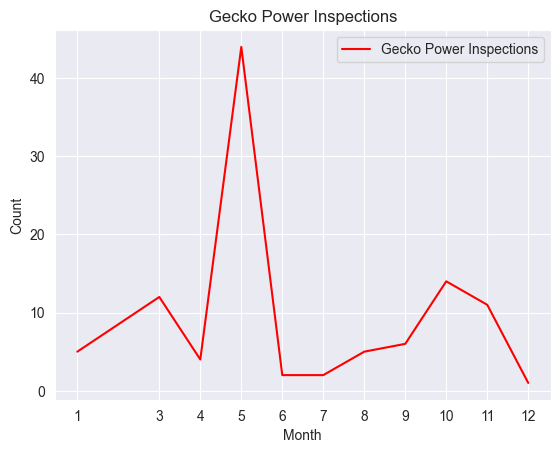

In [184]:
fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

ax.set_title('Gecko Power Inspections')
ax.set_ylabel('Count')
ax.set_xlabel('Month')
ax.set_xticks([1,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(gecko_2022_inspections['Inspection.month'])


ax.plot(gecko_2022_inspections['Inspection.month'], gecko_2022_inspections['inspections'], c='r', label='Gecko Power Inspections')


plt.legend()
plt.draw()

The world is grappling with the current energy crisis, meanwhile US energy infrastructure is failing us.  

Our data shows that the most outages occur when generation is at its peak.

Generation peaks when consumption peaks and peak consumption occurs during extreme weather events.

Weather is becoming more extreme and extreme weather is occuring more frequently.

The most efficient assets are running the most often but when failure occurs in efficient assets, less efficient assets are used, and when those fail, we experience outages.

(Wind turbines shut off in high winds, solar panels require sunlight, fossil fuel burning assets fail...)

Over time these events lead to increased electricity prices for consumers and increased emissions from low efficiency plants.

(YoY consumer electricity prices are climbing rapidly)

We need to transition from a reactive to a proactive maintenance strategy, and it all starts with gathering baseline data on asset health.

In 2022 Gecko inspected 45 utility scale boilers, and discovered that 25% of boilers inspected are at X risk of failure within the next 12 months

Secondary statement on the region that is most at risk ... midwest is twice as likely in our experience

Coal is biggest contributor then nat gas etc